In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from modules.Utils.utils import DummyLogger
import sqlite3
from tqdm import tqdm
import time
import subprocess
import matplotlib.dates as mdates
from datetime import datetime
from astropy.table import Table
from tqdm.notebook import tqdm_notebook
from modules.quicklook.src.analyze_time_series import AnalyzeTimeSeries
!pip install seaborn
import seaborn as sns

from matplotlib.ticker import FuncFormatter
def format_thousands(value, tick_number):
    return f'{int(value / 1000)}k'

import matplotlib.ticker as ticker
plt.rcParams.update({'font.size': 20})

%matplotlib inline

     |████████████████████████████████| 292 kB 3.4 MB/s            


In [2]:
db_path = 'kpf_ts_oct2024_v3.db' # name of database file
db_path_2 = 'kpf_ts_aug_oct2024_v5.db'
myTS = AnalyzeTimeSeries(db_path=db_path)
myTS2 = AnalyzeTimeSeries(db_path=db_path_2)

INFO: Starting AnalyzeTimeSeries
INFO: Jupyter Notebook environment detected.
INFO: Path of database file: /code/KPF-Pipeline/kpf_ts_oct2024_v3.db
INFO: Base data directory: /data/L0
INFO: Primary table 'kpfdb' created/updated successfully.
INFO: Metadata table 'kpfdb_metadata' created/updated successfully.
INFO: Summary: 33057 obs x 1214 cols over 57 days in 20240901-20241027; updated 2025-02-27 03:47:04
INFO: Starting AnalyzeTimeSeries
INFO: Jupyter Notebook environment detected.
INFO: Path of database file: /code/KPF-Pipeline/kpf_ts_aug_oct2024_v5.db
INFO: Base data directory: /data/L0
INFO: Primary table 'kpfdb' created/updated successfully.
INFO: Metadata table 'kpfdb_metadata' created/updated successfully.
INFO: Summary: 14928 obs x 1661 cols over 27 days in 20241001-20241027; updated 2025-04-03 04:48:16


In [3]:
conn = sqlite3.connect(db_path)
cursor = conn.cursor()
cursor.execute(
    """
    SELECT keyword, description
    FROM kpfdb_metadata
    WHERE source = "L2 RV Extension"
    ORDER BY keyword;
    """)
rows = cursor.fetchall()
keywords = [f'"{keyword}"' for keyword, description in rows if keyword]

query = f"""SELECT ObsID, OBJECT, [DATE-MID], NOTJUNK, GOODREAD, CCFBCV, CCFBJD as 'CCFBJD_Avg', BCVRNG, BCVSTD, EXPTIME, GAIAMAG, [2MASSMAG], TARGTEFF, [EMDATE-B], [EMDATE-E], L0_filename,   
    {', '.join(keywords)} 
    FROM kpfdb
    WHERE NOTJUNK = 1.0 AND OBJECT NOT LIKE '%autocal%' AND Source = 'Star'"""
df = pd.read_sql_query(query, conn)
conn.close()
df

,ObsID,OBJECT,DATE-MID,NOTJUNK,GOODREAD,CCFBCV,CCFBJD_Avg,BCVRNG,BCVSTD,EXPTIME,...,RVY57,RVY58,RVY59,RVY60,RVY61,RVY62,RVY63,RVY64,RVY65,RVY66
0,KP.20240901.25709.46,201092,2024-09-01T07:08:59.472,1,None,-0.735386,2.460555e+06,NaN,NaN,60.0,...,0.0,73.9994503492939,87.6714544762298,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,KP.20240901.25818.06,201092,2024-09-01T07:10:48.073,1,None,-0.738219,2.460555e+06,NaN,NaN,60.0,...,0.0,76.5204767988828,-60.1857207938152,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,KP.20240901.25926.46,201092,2024-09-01T07:12:36.475,1,None,-0.741102,2.460555e+06,NaN,NaN,60.0,...,0.0,-8.66980641338825,17.2859798390395,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,KP.20240901.26200.94,TIC198162530,2024-09-01T07:21:40.954,1,None,-3.289237,2.460555e+06,NaN,NaN,600.0,...,0.0,-95.7725969275614,-90.7507848517297,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,KP.20240901.26961.63,142373,2024-09-01T07:29:51.644,1,None,-12.738138,2.460555e+06,NaN,NaN,60.0,...,0.0,-60.2793117313946,-60.523441115301,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4498,KP.20241026.49181.48,52711,2024-10-26T13:44:04.989,1,None,28.050886,2.460610e+06,0.096732,0.020964,527.0,...,0.0,22.7169217062974,-38.2785349674322,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4499,KP.20241026.49992.37,HIP37217,2024-10-26T14:04:50.091,1,None,22.411861,2.460610e+06,1.072112,0.269831,1569.0,...,0.0,-1.92022982588995,65.4683625601405,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4500,KP.20241026.51667.01,44219,2024-10-26T14:22:18.551,1,None,21.881098,2.460610e+06,0.127194,0.029238,143.0,...,0.0,-112.696855858522,15.7976897824488,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4501,KP.20241026.52204.35,HAT-P-20,2024-10-26T14:37:01.365,1,None,29.100836,2.460610e+06,2.947692,0.721304,1685.0,...,0.0,30.9935161416225,0.353441354465979,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
conn = sqlite3.connect(db_path_2)
cursor = conn.cursor()
cursor.execute(
    """
    SELECT keyword, description
    FROM kpfdb_metadata
    WHERE source = "L2 RV Extension"
    ORDER BY keyword;
    """)
rows = cursor.fetchall()
keywords = [f'"{keyword}"' for keyword, description in rows if keyword]

query = f"""SELECT ObsID, OBJECT, [DATE-MID], NOTJUNK, GOODREAD, CCFBCV, CCFBJD as 'CCFBJD_Avg', BCVRNG, BCVSTD, EXPTIME, GAIAMAG, [2MASSMAG], TARGTEFF, [EMDATE-B], [EMDATE-E], L0_filename,   
    {', '.join(keywords)} 
    FROM kpfdb
    WHERE NOTJUNK = 1.0 AND OBJECT NOT LIKE '%autocal%' AND Source = 'Star'"""
df2 = pd.read_sql_query(query, conn)
conn.close()
df2

,ObsID,OBJECT,DATE-MID,NOTJUNK,GOODREAD,CCFBCV,CCFBJD_Avg,BCVRNG,BCVSTD,EXPTIME,...,RVY57,RVY58,RVY59,RVY60,RVY61,RVY62,RVY63,RVY64,RVY65,RVY66
0,KP.20241003.18211.46,TOI-1386,2024-10-03T05:06:01.466,1,1,-0.131280,2.460587e+06,0.073636,0.011272,300.0,...,0.0,40.1197663949349,-9.42646404851718,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,KP.20241003.17479.33,TOI-1386,2024-10-03T04:53:49.337,1,1,-0.118955,2.460587e+06,0.053944,0.015020,300.0,...,0.0,14.5252828639356,-45.2726890644744,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,KP.20241003.17827.92,TOI-1386,2024-10-03T04:59:37.931,1,1,-0.124846,2.460587e+06,0.042110,0.010228,300.0,...,0.0,-17.7247616808119,-21.6676879790056,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,KP.20241003.18560.27,TOI-1386,2024-10-03T05:11:50.282,1,1,-0.137395,2.460587e+06,0.063357,0.015754,300.0,...,0.0,48.9718064508538,-53.4440585821226,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,KP.20241003.18908.70,TOI-1386,2024-10-03T05:17:38.707,1,1,-0.143564,2.460587e+06,0.062673,0.016973,300.0,...,0.0,18.7762078591797,26.8575954190302,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,KP.20241026.49181.48,52711,2024-10-26T13:44:04.989,1,1,28.050886,2.460610e+06,0.096732,0.020964,527.0,...,0.0,22.8079071757091,-38.2794946922266,0.0,0.0,0.0,0.0,0.0,0.0,0.0
776,KP.20241026.49992.37,HIP37217,2024-10-26T14:04:50.091,1,1,22.411861,2.460610e+06,1.072112,0.269831,1569.0,...,0.0,31.4657490420772,6.41234085351726,0.0,0.0,0.0,0.0,0.0,0.0,0.0
777,KP.20241026.51667.01,44219,2024-10-26T14:22:18.551,1,1,21.881098,2.460610e+06,0.127194,0.029238,143.0,...,0.0,59.2130623199443,-1.58107480570477,0.0,0.0,0.0,0.0,0.0,0.0,0.0
778,KP.20241026.52204.35,HAT-P-20,2024-10-26T14:37:01.365,1,1,29.100836,2.460610e+06,2.947692,0.721304,1685.0,...,0.0,50.1892004087188,-34.6287710886112,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
#identifying columns to reshape (the ones ending with digits)
columns_to_reshape = [col for col in df.columns if col[-2:].isdigit()]

#extracting ORDER and prefix from the column names
order_list = []
prefix_list = []
for col in columns_to_reshape:
    prefix = col[:-2]  # Extract the prefix (e.g., 'BCRV')
    order = col[-2:]   # Extract the order (e.g., '00')
    prefix_list.append(prefix)
    order_list.append(order)

#creating new dataframe with ORDER 
unique_orders = sorted(set(order_list))  # Unique ORDER values
new_df = pd.DataFrame({
    'ORDER': unique_orders,
})

#add preserved columns to the new dataframe
preserved_columns = ['ObsID', 'OBJECT', 'DATE-MID', 'CCFBCV', 'CCFBJD_Avg', 'BCVRNG', 'BCVSTD', 'EXPTIME', 'GAIAMAG', '2MASSMAG', 'TARGTEFF', 'EMDATE-B', 'EMDATE-E', 'L0_filename']
temp_df = df[preserved_columns].assign(key=1)
new_df = new_df.assign(key=1).merge(temp_df, on='key', how='outer').drop('key', axis=1)

#adding columns for each unique prefix
unique_prefixes = set(prefix_list)
for prefix in unique_prefixes:
    new_df[prefix] = None  # Initialize the column with None

#populating the new DataFrame with values from the original DataFrame
for i, col in enumerate(columns_to_reshape):
    prefix = prefix_list[i]
    order = order_list[i]
    new_df.loc[new_df['ORDER'] == order, prefix] = df[col].values

#sorting the DataFrame by preserved columns and ORDER
new_df = new_df.sort_values(by=preserved_columns + ['ORDER']).reset_index(drop=True)

new_df

,ORDER,ObsID,OBJECT,DATE-MID,CCFBCV,CCFBJD_Avg,BCVRNG,BCVSTD,EXPTIME,GAIAMAG,...,RVC,RV3,ERVC,RV2,RVY,CCFBJD,ERVS,RVS,ERVY,BCRV
0,00,KP.20240901.25709.46,201092,2024-09-01T07:08:59.472,-0.735386,2.460555e+06,NaN,NaN,60.0,5.45,...,0.0,0.0,0.0,0.0,0.0,2460554.80228612,0.00371330351343654,0.0,0.0,-0.735393310978223
1,01,KP.20240901.25709.46,201092,2024-09-01T07:08:59.472,-0.735386,2.460555e+06,NaN,NaN,60.0,5.45,...,0.0,0.0,0.0,0.0,0.0,2460554.80228201,0.00353493677869039,0.0,0.0,-0.735383983169038
2,02,KP.20240901.25709.46,201092,2024-09-01T07:08:59.472,-0.735386,2.460555e+06,NaN,NaN,60.0,5.45,...,0.0,0.0,0.0,0.0,0.0,2460554.80228251,0.00271216561490699,0.0,0.0,-0.735385113215487
3,03,KP.20240901.25709.46,201092,2024-09-01T07:08:59.472,-0.735386,2.460555e+06,NaN,NaN,60.0,5.45,...,0.0,0.0,0.0,0.0,0.0,2460554.80228298,0.00283316785135073,0.0,0.0,-0.735386190340934
4,04,KP.20240901.25709.46,201092,2024-09-01T07:08:59.472,-0.735386,2.460555e+06,NaN,NaN,60.0,5.45,...,0.0,0.0,0.0,0.0,0.0,2460554.80228258,0.00228852358975969,0.0,0.0,-0.735385270746997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301696,62,KP.20241026.53485.57,88230,2024-10-26T14:53:55.582,24.197612,2.460610e+06,0.094083,0.02072,300.0,5.96,...,0.00914154823921011,0.0,0.000475514395909022,0.0,0.0,2460610.12080313,0.0,0.0,0.0,24.1976159080732
301697,63,KP.20241026.53485.57,88230,2024-10-26T14:53:55.582,24.197612,2.460610e+06,0.094083,0.02072,300.0,5.96,...,-0.000684368049018988,0.0,0.000440153840225037,0.0,0.0,2460610.12079732,0.0,0.0,0.0,24.1976221527514
301698,64,KP.20241026.53485.57,88230,2024-10-26T14:53:55.582,24.197612,2.460610e+06,0.094083,0.02072,300.0,5.96,...,0.0114146858877544,0.0,0.00086853335713448,0.0,0.0,2460610.12079346,0.0,0.0,0.0,24.1976263076159
301699,65,KP.20241026.53485.57,88230,2024-10-26T14:53:55.582,24.197612,2.460610e+06,0.094083,0.02072,300.0,5.96,...,-0.00788511566110868,0.0,0.00080678890915096,0.0,0.0,2460610.12079598,0.0,0.0,0.0,24.197623595531


In [7]:
#identifying columns to reshape (the ones ending with digits)
columns_to_reshape = [col for col in df2.columns if col[-2:].isdigit()]

#extracting ORDER and prefix from the column names
order_list = []
prefix_list = []
for col in columns_to_reshape:
    prefix = col[:-2]  # Extract the prefix (e.g., 'BCRV')
    order = col[-2:]   # Extract the order (e.g., '00')
    prefix_list.append(prefix)
    order_list.append(order)

#creating new dataframe with ORDER 
unique_orders = sorted(set(order_list))  # Unique ORDER values
new_df2 = pd.DataFrame({
    'ORDER': unique_orders,
})

#add preserved columns to the new dataframe
preserved_columns = ['ObsID', 'OBJECT', 'DATE-MID', 'CCFBCV', 'CCFBJD_Avg', 'BCVRNG', 'BCVSTD', 'EXPTIME', 'GAIAMAG', '2MASSMAG', 'TARGTEFF', 'EMDATE-B', 'EMDATE-E', 'L0_filename']
temp_df = df2[preserved_columns].assign(key=1)
new_df2 = new_df2.assign(key=1).merge(temp_df, on='key', how='outer').drop('key', axis=1)

#adding columns for each unique prefix
unique_prefixes = set(prefix_list)
for prefix in unique_prefixes:
    new_df2[prefix] = None  # Initialize the column with None

#populating the new DataFrame with values from the original DataFrame
for i, col in enumerate(columns_to_reshape):
    prefix = prefix_list[i]
    order = order_list[i]
    new_df2.loc[new_df2['ORDER'] == order, prefix] = df2[col].values

#sorting the DataFrame by preserved columns and ORDER
new_df2 = new_df2.sort_values(by=preserved_columns + ['ORDER']).reset_index(drop=True)

new_df2

,ORDER,ObsID,OBJECT,DATE-MID,CCFBCV,CCFBJD_Avg,BCVRNG,BCVSTD,EXPTIME,GAIAMAG,...,RVC,RV3,ERVC,RV2,RVY,CCFBJD,ERVS,RVS,ERVY,BCRV
0,00,KP.20241003.16753.55,166620,2024-10-03T04:43:23.562,-14.018317,2.460587e+06,0.025817,0.007962,500.0,6.13,...,0.0,0.0,0.000135777855409152,0.0,0.0,2460586.69730111,0.00110303382679422,0.0,0.0,-14.0183402682842
1,01,KP.20241003.16753.55,166620,2024-10-03T04:43:23.562,-14.018317,2.460587e+06,0.025817,0.007962,500.0,6.13,...,0.0,0.0,0.000108311991762475,0.0,0.0,2460586.69730067,0.000993804929927272,0.0,0.0,-14.0183393628691
2,02,KP.20241003.16753.55,166620,2024-10-03T04:43:23.562,-14.018317,2.460587e+06,0.025817,0.007962,500.0,6.13,...,0.0,0.0,9.01613317578419e-05,0.0,0.0,2460586.6973004,0.000760440468688483,0.0,0.0,-14.018338814288
3,03,KP.20241003.16753.55,166620,2024-10-03T04:43:23.562,-14.018317,2.460587e+06,0.025817,0.007962,500.0,6.13,...,0.0,0.0,7.78472500084967e-05,0.0,0.0,2460586.69729784,0.000790731369514438,0.0,0.0,-14.0183335460522
4,04,KP.20241003.16753.55,166620,2024-10-03T04:43:23.562,-14.018317,2.460587e+06,0.025817,0.007962,500.0,6.13,...,0.0,0.0,7.11582103142172e-05,0.0,0.0,2460586.6972992,0.000732112497697409,0.0,0.0,-14.0183363350888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52255,62,KP.20241026.53485.57,88230,2024-10-26T14:53:55.582,24.197612,2.460610e+06,0.094084,0.020720,300.0,5.96,...,-0.00128912060098457,0.0,9.73018008924353e-05,0.0,0.0,2460610.12080313,0.0,0.0,0.0,24.1976159075407
52256,63,KP.20241026.53485.57,88230,2024-10-26T14:53:55.582,24.197612,2.460610e+06,0.094084,0.020720,300.0,5.96,...,-0.00383490444933316,0.0,0.00010444581427817,0.0,0.0,2460610.12079732,0.0,0.0,0.0,24.1976221522189
52257,64,KP.20241026.53485.57,88230,2024-10-26T14:53:55.582,24.197612,2.460610e+06,0.094084,0.020720,300.0,5.96,...,-0.00204785260511674,0.0,0.000109780498308093,0.0,0.0,2460610.12079346,0.0,0.0,0.0,24.1976263071499
52258,65,KP.20241026.53485.57,88230,2024-10-26T14:53:55.582,24.197612,2.460610e+06,0.094084,0.020720,300.0,5.96,...,-0.00262394488651741,0.0,0.000118478028575238,0.0,0.0,2460610.12079598,0.0,0.0,0.0,24.1976235950651


In [8]:
#filtering out zero weights
new_df = new_df.loc[new_df['CCFW'].astype(float) > 0.0].copy()

#BCRV as m/s, CCFBJ as seconds, and with correction
new_df.loc[:, 'BCRV_Corr'] = (new_df['BCRV'].astype(float) * 1000) - (new_df['CCFBCV'].astype(float)*1000)
new_df.loc[:, 'CCFBJ_Corr'] = (new_df['CCFBJD'].astype(float) - new_df['CCFBJD_Avg'].astype(float)) * 86400
new_df['ORDER'] = new_df['ORDER'].astype(str)

#filtering out zero weights
new_df2 = new_df2.loc[new_df2['CCFW'].astype(float) > 0.0].copy()

#BCRV as m/s, CCFBJ as seconds, and with correction
new_df2.loc[:, 'BCRV_Corr'] = (new_df2['BCRV'].astype(float) * 1000) - (new_df2['CCFBCV'].astype(float)*1000)
new_df2.loc[:, 'CCFBJ_Corr'] = (new_df2['CCFBJD'].astype(float) - new_df2['CCFBJD_Avg'].astype(float)) * 86400
new_df2['ORDER'] = new_df2['ORDER'].astype(str)

In [9]:
#normalizing BCRV_Corr and CCFBJ_Corr with respect to EXPTIME
new_df.loc[:, 'BCRV_Norm'] = new_df['BCRV_Corr'] / new_df['EXPTIME'].astype(float)
new_df.loc[:, 'BJD_Norm'] = new_df['CCFBJ_Corr'] / new_df['EXPTIME'].astype(float)

#setting datatypes
new_df['BCVRNG'] = new_df['BCVRNG'].astype(float)
new_df['GAIAMAG'] = pd.to_numeric(new_df['GAIAMAG'], errors='coerce')
new_df['2MASSMAG'] = pd.to_numeric(new_df['2MASSMAG'], errors='coerce')
new_df['TARGTEFF'] = new_df['TARGTEFF'].astype(float)
new_df['EXPTIME'] = new_df['EXPTIME'].astype(float)

#changing any temperature above 40K to 5770
new_df.loc[new_df['TARGTEFF'] > 40000, 'TARGTEFF'] = 5770

#normalizing BCRV_Corr and CCFBJ_Corr with respect to EXPTIME
new_df2.loc[:, 'BCRV_Norm'] = new_df2['BCRV_Corr'] / new_df2['EXPTIME'].astype(float)
new_df2.loc[:, 'BJD_Norm'] = new_df2['CCFBJ_Corr'] / new_df2['EXPTIME'].astype(float)

#setting datatypes
new_df2['BCVRNG'] = new_df2['BCVRNG'].astype(float)
new_df2['GAIAMAG'] = pd.to_numeric(new_df2['GAIAMAG'], errors='coerce')
new_df2['2MASSMAG'] = pd.to_numeric(new_df2['2MASSMAG'], errors='coerce')
new_df2['TARGTEFF'] = new_df2['TARGTEFF'].astype(float)
new_df2['EXPTIME'] = new_df2['EXPTIME'].astype(float)

#changing any temperature above 40K to 5770
new_df2.loc[new_df2['TARGTEFF'] > 40000, 'TARGTEFF'] = 5770

In [10]:

new_df = new_df.sort_values(by=['ORDER'], ascending=True)

new_df2 = new_df2.sort_values(by=['ORDER'], ascending=True)

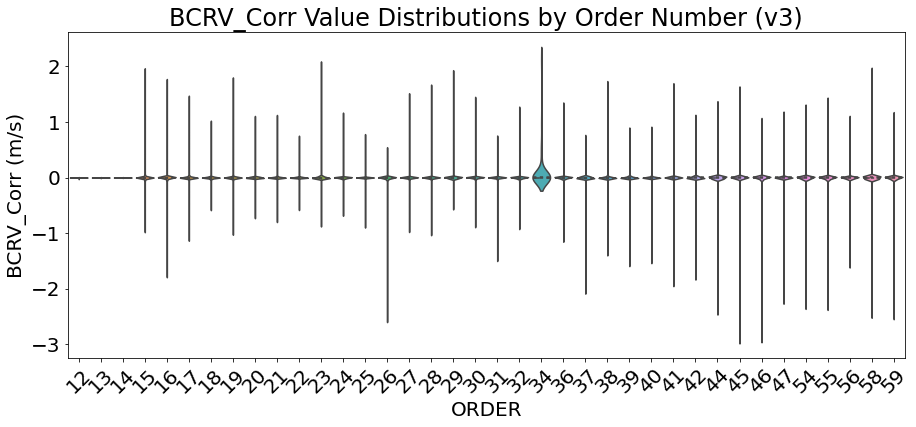

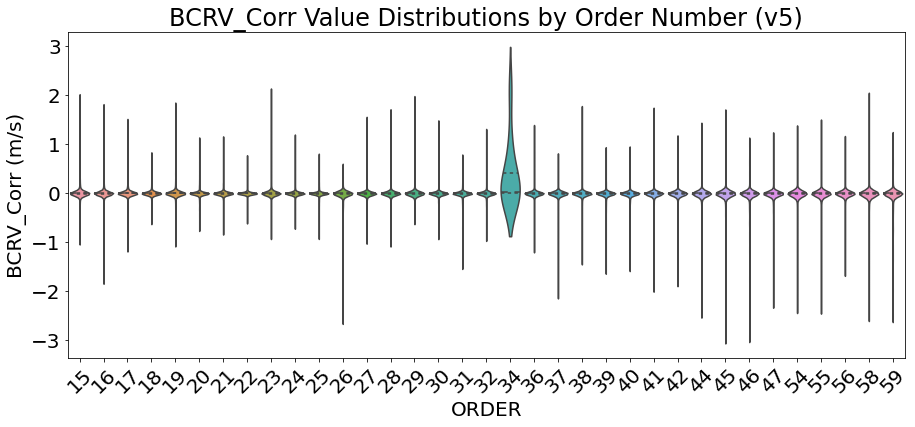

In [12]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(15, 6))
sns.violinplot(x="ORDER", y="BCRV_Corr", data=new_df, scale="width", inner="quartile")
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.title("BCRV_Corr Value Distributions by Order Number (v3)")
plt.ylabel('BCRV_Corr (m/s)')
plt.show()

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(15, 6))
sns.violinplot(x="ORDER", y="BCRV_Corr", data=new_df2, scale="width", inner="quartile")
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.title("BCRV_Corr Value Distributions by Order Number (v5)")
plt.ylabel('BCRV_Corr (m/s)')
plt.show()

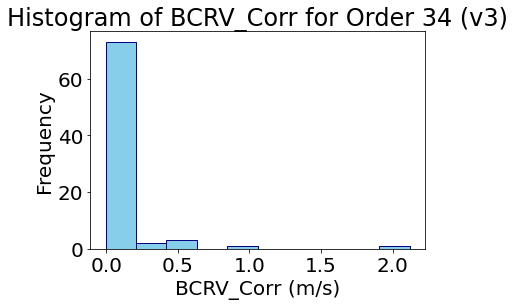

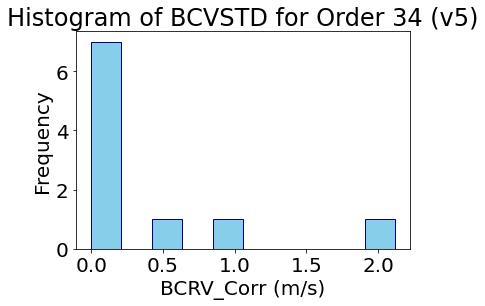

In [46]:
df_34 = new_df[new_df['ORDER'] == '34']
df_34_2 = new_df2[new_df2['ORDER'] == '34']

plt.hist(df_34['BCRV_Corr'], bins=10, color='skyblue', edgecolor='navy')
plt.title('Histogram of BCRV_Corr for Order 34 (v3)')
plt.xlabel("BCRV_Corr (m/s)")
plt.ylabel("Frequency")
plt.show()

plt.hist(df_34_2['BCRV_Corr'], bins=10, color='skyblue', edgecolor='navy')
plt.title('Histogram of BCVSTD for Order 34 (v5)')
plt.xlabel("BCRV_Corr (m/s)")
plt.ylabel("Frequency")
plt.show()

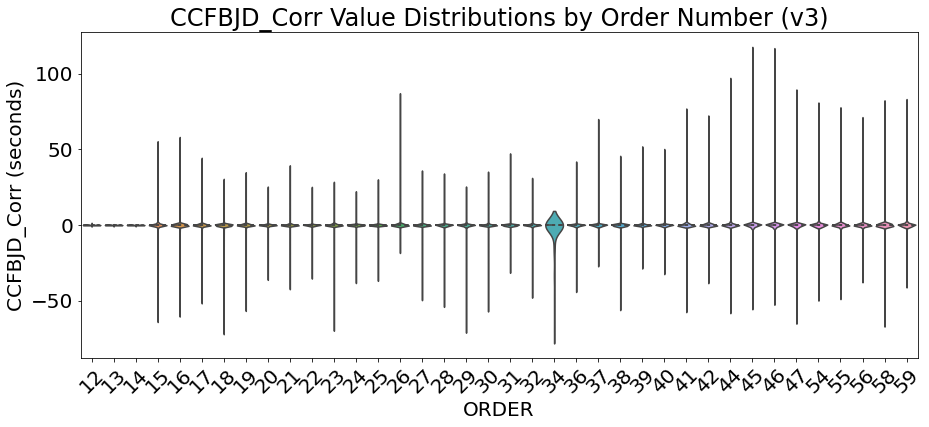

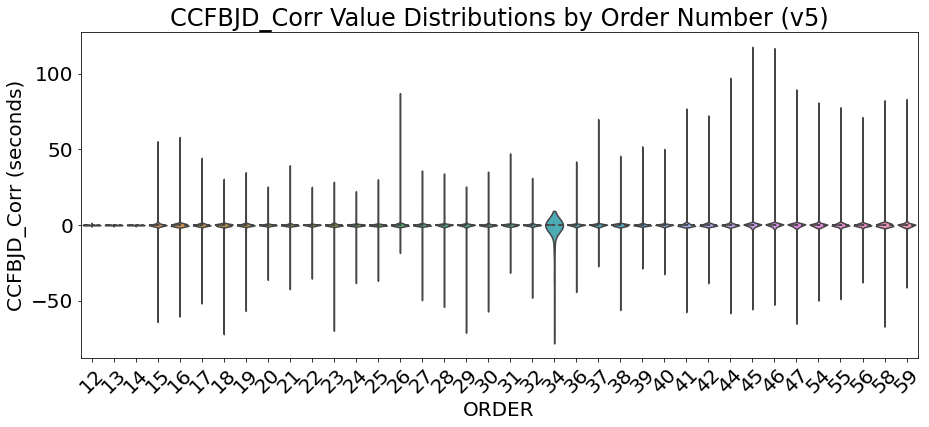

In [13]:
plt.figure(figsize=(15, 6))
sns.violinplot(x="ORDER", y="CCFBJ_Corr", data=new_df, scale="width", inner="quartile")
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.title("CCFBJD_Corr Value Distributions by Order Number (v3)")
plt.ylabel('CCFBJD_Corr (seconds)')
plt.show()

plt.figure(figsize=(15, 6))
sns.violinplot(x="ORDER", y="CCFBJ_Corr", data=new_df, scale="width", inner="quartile")
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.title("CCFBJD_Corr Value Distributions by Order Number (v5)")
plt.ylabel('CCFBJD_Corr (seconds)')
plt.show()

In [20]:
BJSortHigh = new_df.sort_values(by='CCFBJ_Corr', ascending=False)
print(BJSortHigh[['ORDER', 'CCFBJ_Corr', 'L0_filename']].head())

BJSortHigh2 = new_df2.sort_values(by='CCFBJ_Corr', ascending=False)
print(BJSortHigh2[['ORDER', 'CCFBJ_Corr', 'L0_filename']].head())

       ORDER  CCFBJ_Corr                L0_filename
273204    45  116.149521  KP.20241016.55598.79.fits
273205    46  115.453126  KP.20241016.55598.79.fits
273203    44   95.759127  KP.20241016.55598.79.fits
273206    47   88.196504  KP.20241016.55598.79.fits
284910    26   85.968031  KP.20241021.32152.40.fits
      ORDER  CCFBJ_Corr                L0_filename
23763    45  116.149521  KP.20241016.55598.79.fits
23764    46  115.453126  KP.20241016.55598.79.fits
23762    44   95.759127  KP.20241016.55598.79.fits
23765    47   88.196504  KP.20241016.55598.79.fits
35469    26   85.968031  KP.20241021.32152.40.fits


In [21]:
BJSortLow = new_df.sort_values(by='CCFBJ_Corr', ascending=True)
print(BJSortLow[['ORDER', 'CCFBJ_Corr', 'L0_filename']].head())

BJSortLow2 = new_df2.sort_values(by='CCFBJ_Corr', ascending=True)
print(BJSortLow2[['ORDER', 'CCFBJ_Corr', 'L0_filename']].head())

       ORDER  CCFBJ_Corr                L0_filename
41759     18  -70.985050  KP.20240919.23861.94.fits
76275     29  -70.024605  KP.20240925.25892.64.fits
269441    34  -68.961726  KP.20241015.32865.99.fits
284907    23  -68.882386  KP.20241021.32152.40.fits
301625    58  -65.383713  KP.20241026.52204.35.fits
      ORDER  CCFBJ_Corr                L0_filename
20000    34  -68.961726  KP.20241015.32865.99.fits
35466    23  -68.882386  KP.20241021.32152.40.fits
52184    58  -65.383753  KP.20241026.52204.35.fits
44535    47  -63.794665  KP.20241023.28670.41.fits
31170    15  -62.819615  KP.20241020.43635.09.fits


In [22]:
BCVSortHigh = new_df.sort_values(by='BCRV_Corr', ascending=False)
print(BCVSortHigh[['ORDER', 'BCRV_Corr', 'L0_filename']].head())

BCVSortHigh2 = new_df2.sort_values(by='BCRV_Corr', ascending=False)
print(BCVSortHigh2[['ORDER', 'BCRV_Corr', 'L0_filename']].head())

       ORDER  BCRV_Corr                L0_filename
269441    34   2.119836  KP.20241015.32865.99.fits
284907    23   2.068891  KP.20241021.32152.40.fits
280611    15   1.941600  KP.20241020.43635.09.fits
301625    58   1.941022  KP.20241026.52204.35.fits
267292    29   1.908048  KP.20241013.33188.96.fits
      ORDER  BCRV_Corr                L0_filename
20000    34   2.119836  KP.20241015.32865.99.fits
35466    23   2.068891  KP.20241021.32152.40.fits
31170    15   1.941600  KP.20241020.43635.09.fits
52184    58   1.941022  KP.20241026.52204.35.fits
17851    29   1.908048  KP.20241013.33188.96.fits


In [23]:
BCVSortLow = new_df.sort_values(by='BCRV_Corr', ascending=True)
print(BCVSortLow[['ORDER', 'BCRV_Corr', 'L0_filename']].head())

BCVSortLow = new_df.sort_values(by='BCRV_Corr', ascending=True)
print(BCVSortLow[['ORDER', 'BCRV_Corr', 'L0_filename']].head())

       ORDER  BCRV_Corr                L0_filename
273204    45  -2.953816  KP.20241016.55598.79.fits
273205    46  -2.936147  KP.20241016.55598.79.fits
284910    26  -2.576222  KP.20241021.32152.40.fits
280655    59  -2.515962  KP.20241020.43635.09.fits
280654    58  -2.489818  KP.20241020.43635.09.fits
       ORDER  BCRV_Corr                L0_filename
273204    45  -2.953816  KP.20241016.55598.79.fits
273205    46  -2.936147  KP.20241016.55598.79.fits
284910    26  -2.576222  KP.20241021.32152.40.fits
280655    59  -2.515962  KP.20241020.43635.09.fits
280654    58  -2.489818  KP.20241020.43635.09.fits


In [25]:
#grouping by observation and getting min and max of BCRV_Corr and CCFBJ_Corr
grouped = new_df.groupby('ObsID').agg({
    'BCRV_Corr': [np.min, np.max],
    'BCRV_Norm': [np.min, np.max],
    'CCFBJ_Corr': [np.min, np.max],
    'BJD_Norm': [np.min, np.max],
    'BCVRNG': [np.max],
    'GAIAMAG': [np.max],
    '2MASSMAG': [np.max],
    'TARGTEFF': [np.max],
    'EXPTIME': [np.max]
})

#grouping by observation and getting min and max of BCRV_Corr and CCFBJ_Corr
grouped2 = new_df2.groupby('ObsID').agg({
    'BCRV_Corr': [np.min, np.max],
    'BCRV_Norm': [np.min, np.max],
    'CCFBJ_Corr': [np.min, np.max],
    'BJD_Norm': [np.min, np.max],
    'BCVRNG': [np.max],
    'GAIAMAG': [np.max],
    '2MASSMAG': [np.max],
    'TARGTEFF': [np.max],
    'EXPTIME': [np.max]
})

grouped2.columns

MultiIndex([( 'BCRV_Corr', 'amin'),
            ( 'BCRV_Corr', 'amax'),
            ( 'BCRV_Norm', 'amin'),
            ( 'BCRV_Norm', 'amax'),
            ('CCFBJ_Corr', 'amin'),
            ('CCFBJ_Corr', 'amax'),
            (  'BJD_Norm', 'amin'),
            (  'BJD_Norm', 'amax'),
            (    'BCVRNG', 'amax'),
            (   'GAIAMAG', 'amax'),
            (  '2MASSMAG', 'amax'),
            (  'TARGTEFF', 'amax'),
            (   'EXPTIME', 'amax')],
           )

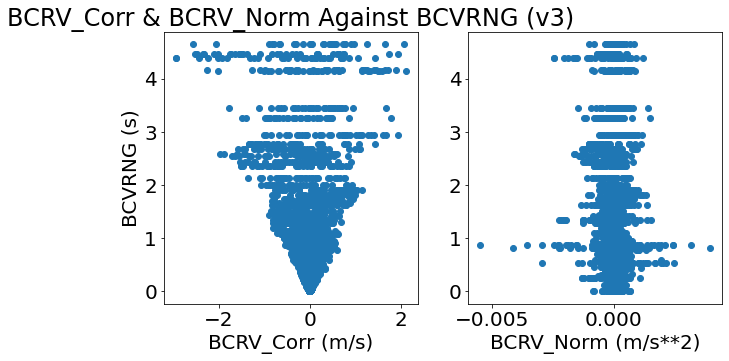

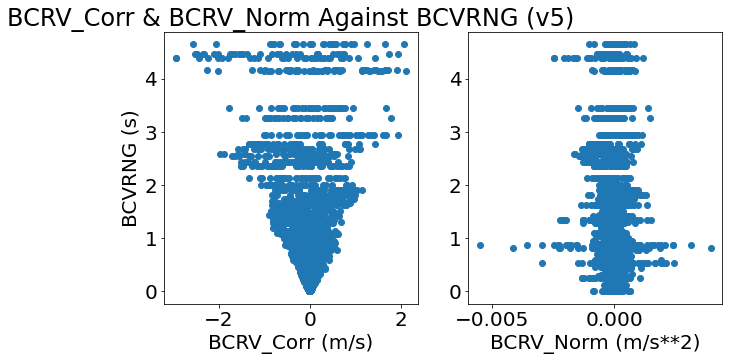

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].scatter(new_df['BCRV_Corr'], new_df['BCVRNG'])
axes[0].set_title('BCRV_Corr & BCRV_Norm Against BCVRNG (v3)')
axes[0].set_xlabel('BCRV_Corr (m/s)')
axes[0].set_ylabel('BCVRNG (s)')
axes[1].scatter(new_df['BCRV_Norm'], new_df['BCVRNG'])
axes[1].set_xlabel('BCRV_Norm (m/s**2)')
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].scatter(new_df2['BCRV_Corr'], new_df2['BCVRNG'])
axes[0].set_title('BCRV_Corr & BCRV_Norm Against BCVRNG (v5)')
axes[0].set_xlabel('BCRV_Corr (m/s)')
axes[0].set_ylabel('BCVRNG (s)')
axes[1].scatter(new_df2['BCRV_Norm'], new_df2['BCVRNG'])
axes[1].set_xlabel('BCRV_Norm (m/s**2)')
plt.show()

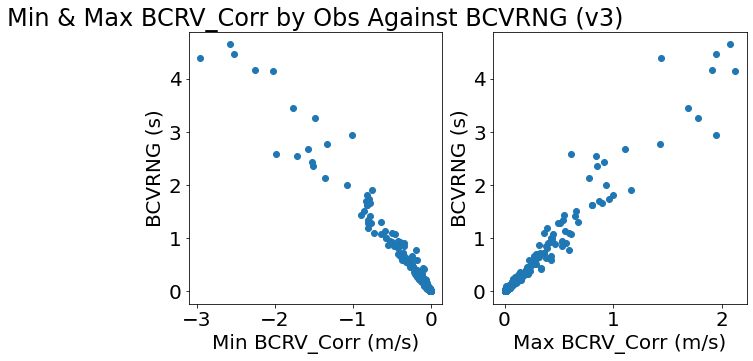

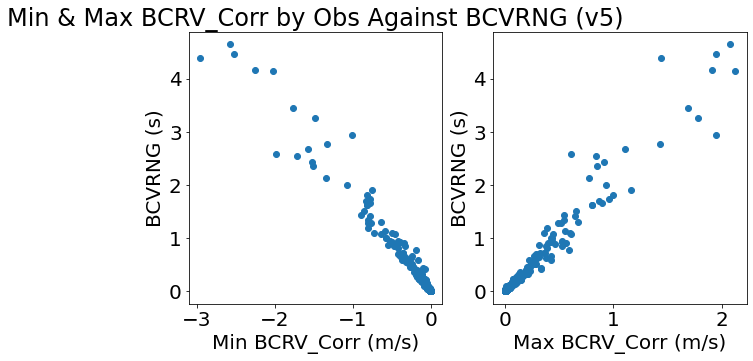

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].scatter(grouped[( 'BCRV_Corr', 'amin')], grouped[(    'BCVRNG', 'amax')])
axes[0].set_title('Min & Max BCRV_Corr by Obs Against BCVRNG (v3)')
axes[0].set_xlabel('Min BCRV_Corr (m/s)')
axes[0].set_ylabel('BCVRNG (s)')
axes[1].scatter(grouped[( 'BCRV_Corr', 'amax')], grouped[(    'BCVRNG', 'amax')])
axes[1].set_xlabel('Max BCRV_Corr (m/s)')
axes[1].set_ylabel('BCVRNG (s)')
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].scatter(grouped2[( 'BCRV_Corr', 'amin')], grouped2[(    'BCVRNG', 'amax')])
axes[0].set_title('Min & Max BCRV_Corr by Obs Against BCVRNG (v5)')
axes[0].set_xlabel('Min BCRV_Corr (m/s)')
axes[0].set_ylabel('BCVRNG (s)')
axes[1].scatter(grouped2[( 'BCRV_Corr', 'amax')], grouped2[(    'BCVRNG', 'amax')])
axes[1].set_xlabel('Max BCRV_Corr (m/s)')
axes[1].set_ylabel('BCVRNG (s)')
plt.show()

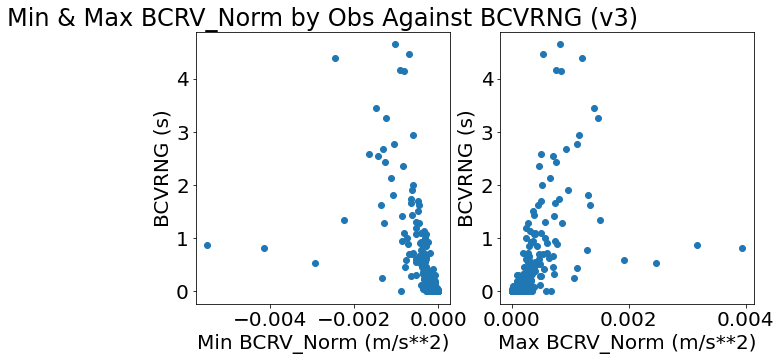

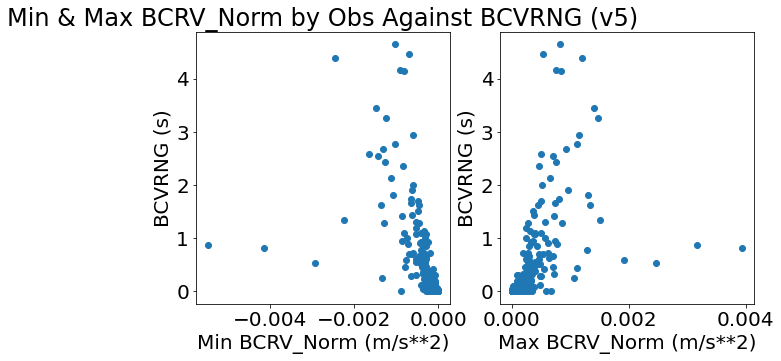

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].scatter(grouped[( 'BCRV_Norm', 'amin')], grouped[(    'BCVRNG', 'amax')])
axes[0].set_title('Min & Max BCRV_Norm by Obs Against BCVRNG (v3)')
axes[0].set_xlabel('Min BCRV_Norm (m/s**2)')
axes[0].set_ylabel('BCVRNG (s)')
axes[1].scatter(grouped[( 'BCRV_Norm', 'amax')], grouped[(    'BCVRNG', 'amax')])
axes[1].set_xlabel('Max BCRV_Norm (m/s**2)')
axes[1].set_ylabel('BCVRNG (s)')
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].scatter(grouped2[( 'BCRV_Norm', 'amin')], grouped2[(    'BCVRNG', 'amax')])
axes[0].set_title('Min & Max BCRV_Norm by Obs Against BCVRNG (v5)')
axes[0].set_xlabel('Min BCRV_Norm (m/s**2)')
axes[0].set_ylabel('BCVRNG (s)')
axes[1].scatter(grouped2[( 'BCRV_Norm', 'amax')], grouped2[(    'BCVRNG', 'amax')])
axes[1].set_xlabel('Max BCRV_Norm (m/s**2)')
axes[1].set_ylabel('BCVRNG (s)')
plt.show()

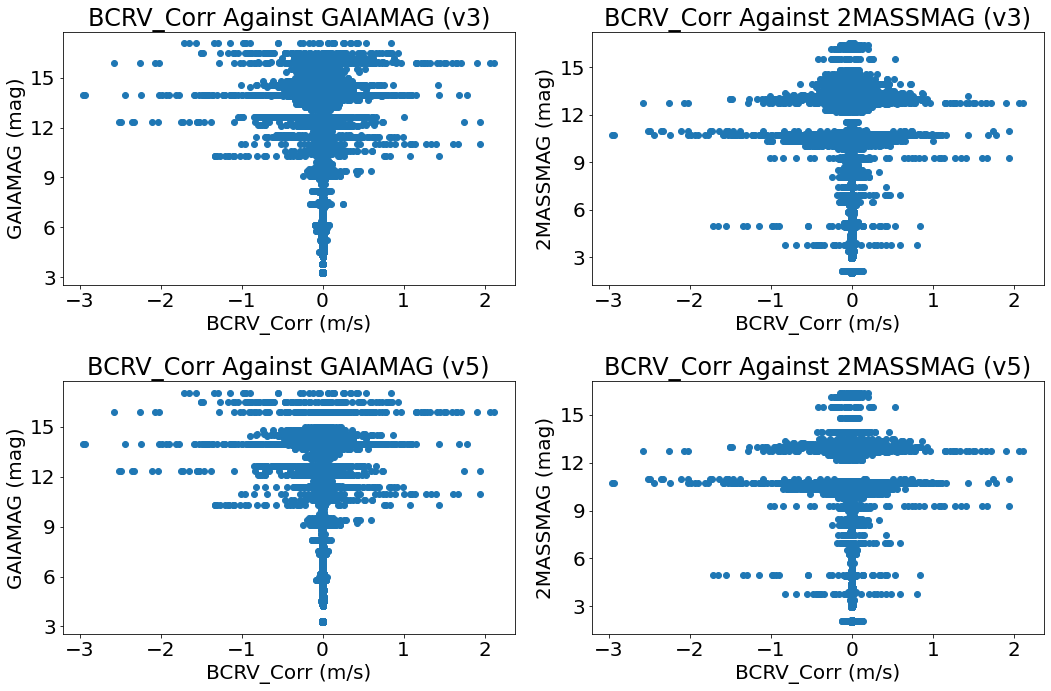

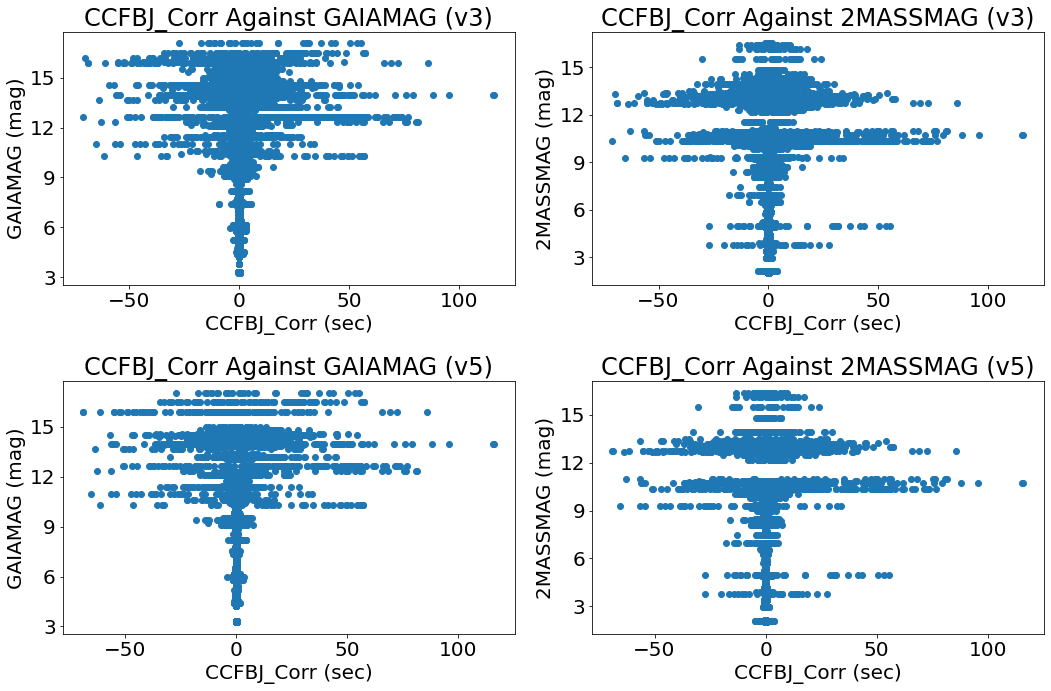

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes[0][0].scatter(new_df['BCRV_Corr'], new_df['GAIAMAG'])
axes[0][0].set_title('BCRV_Corr Against GAIAMAG (v3)')
axes[0][0].set_xlabel('BCRV_Corr (m/s)')
axes[0][0].set_ylabel('GAIAMAG (mag)')
axes[0][0].yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

axes[0][1].scatter(new_df['BCRV_Corr'], new_df['2MASSMAG'])
axes[0][1].set_title('BCRV_Corr Against 2MASSMAG (v3)')
axes[0][1].set_xlabel('BCRV_Corr (m/s)')
axes[0][1].set_ylabel('2MASSMAG (mag)')
axes[0][1].yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

axes[1][0].scatter(new_df2['BCRV_Corr'], new_df2['GAIAMAG'])
axes[1][0].set_title('BCRV_Corr Against GAIAMAG (v5)')
axes[1][0].set_xlabel('BCRV_Corr (m/s)')
axes[1][0].set_ylabel('GAIAMAG (mag)')
axes[1][0].yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

axes[1][1].scatter(new_df2['BCRV_Corr'], new_df2['2MASSMAG'])
axes[1][1].set_title('BCRV_Corr Against 2MASSMAG (v5)')
axes[1][1].set_xlabel('BCRV_Corr (m/s)')
axes[1][1].set_ylabel('2MASSMAG (mag)')
axes[1][1].yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes[0][0].scatter(new_df['CCFBJ_Corr'], new_df['GAIAMAG'])
axes[0][0].set_title('CCFBJ_Corr Against GAIAMAG (v3)')
axes[0][0].set_xlabel('CCFBJ_Corr (sec)')
axes[0][0].set_ylabel('GAIAMAG (mag)')
axes[0][0].yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

axes[0][1].scatter(new_df['CCFBJ_Corr'], new_df['2MASSMAG'])
axes[0][1].set_title('CCFBJ_Corr Against 2MASSMAG (v3)')
axes[0][1].set_xlabel('CCFBJ_Corr (sec)')
axes[0][1].set_ylabel('2MASSMAG (mag)')
axes[0][1].yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

axes[1][0].scatter(new_df2['CCFBJ_Corr'], new_df2['GAIAMAG'])
axes[1][0].set_title('CCFBJ_Corr Against GAIAMAG (v5)')
axes[1][0].set_xlabel('CCFBJ_Corr (sec)')
axes[1][0].set_ylabel('GAIAMAG (mag)')
axes[1][0].yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

axes[1][1].scatter(new_df2['CCFBJ_Corr'], new_df2['2MASSMAG'])
axes[1][1].set_title('CCFBJ_Corr Against 2MASSMAG (v5)')
axes[1][1].set_xlabel('CCFBJ_Corr (sec)')
axes[1][1].set_ylabel('2MASSMAG (mag)')
axes[1][1].yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

plt.tight_layout()
plt.show()

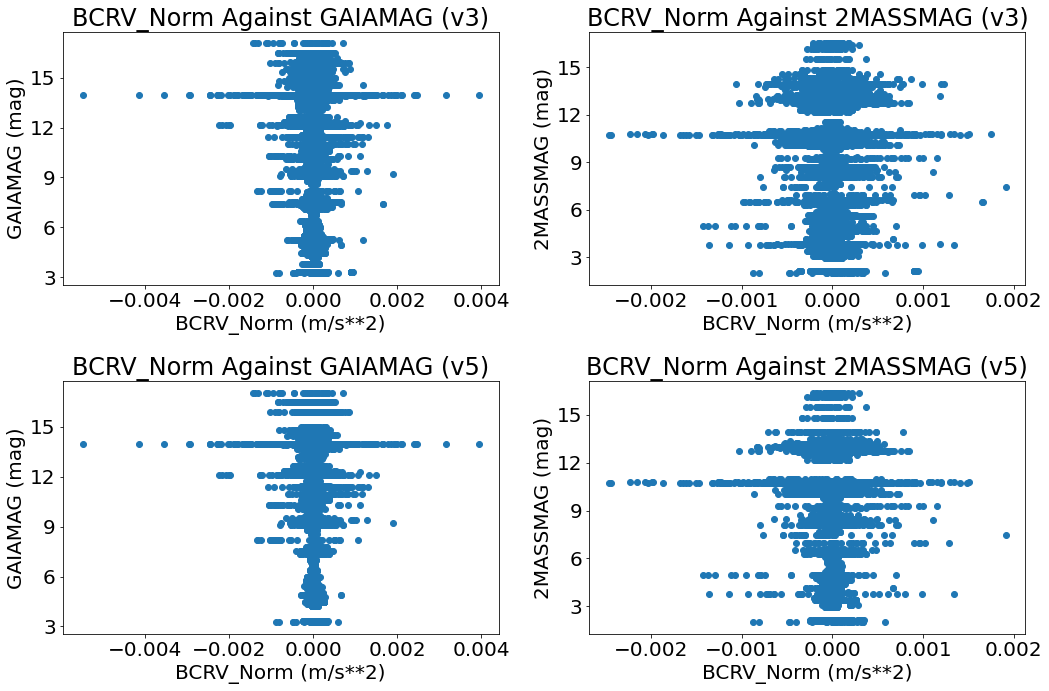

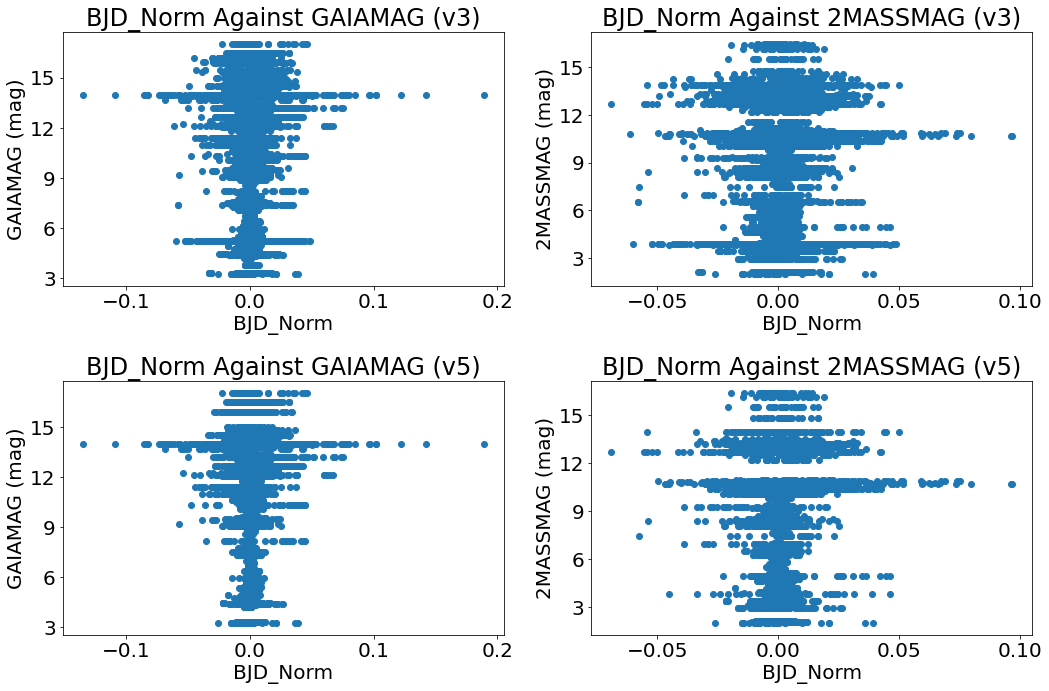

In [32]:

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes[0][0].scatter(new_df['BCRV_Norm'], new_df['GAIAMAG'])
axes[0][0].set_title('BCRV_Norm Against GAIAMAG (v3)')
axes[0][0].set_xlabel('BCRV_Norm (m/s**2)')
axes[0][0].set_ylabel('GAIAMAG (mag)')
axes[0][0].yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

axes[0][1].scatter(new_df['BCRV_Norm'], new_df['2MASSMAG'])
axes[0][1].set_title('BCRV_Norm Against 2MASSMAG (v3)')
axes[0][1].set_xlabel('BCRV_Norm (m/s**2)')
axes[0][1].set_ylabel('2MASSMAG (mag)')
axes[0][1].yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

axes[1][0].scatter(new_df2['BCRV_Norm'], new_df2['GAIAMAG'])
axes[1][0].set_title('BCRV_Norm Against GAIAMAG (v5)')
axes[1][0].set_xlabel('BCRV_Norm (m/s**2)')
axes[1][0].set_ylabel('GAIAMAG (mag)')
axes[1][0].yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

axes[1][1].scatter(new_df2['BCRV_Norm'], new_df2['2MASSMAG'])
axes[1][1].set_title('BCRV_Norm Against 2MASSMAG (v5)')
axes[1][1].set_xlabel('BCRV_Norm (m/s**2)')
axes[1][1].set_ylabel('2MASSMAG (mag)')
axes[1][1].yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes[0][0].scatter(new_df['BJD_Norm'], new_df['GAIAMAG'])
axes[0][0].set_title('BJD_Norm Against GAIAMAG (v3)')
axes[0][0].set_xlabel('BJD_Norm')
axes[0][0].set_ylabel('GAIAMAG (mag)')
axes[0][0].yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

axes[0][1].scatter(new_df['BJD_Norm'], new_df['2MASSMAG'])
axes[0][1].set_title('BJD_Norm Against 2MASSMAG (v3)')
axes[0][1].set_xlabel('BJD_Norm')
axes[0][1].set_ylabel('2MASSMAG (mag)')
axes[0][1].yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

axes[1][0].scatter(new_df2['BJD_Norm'], new_df2['GAIAMAG'])
axes[1][0].set_title('BJD_Norm Against GAIAMAG (v5)')
axes[1][0].set_xlabel('BJD_Norm')
axes[1][0].set_ylabel('GAIAMAG (mag)')
axes[1][0].yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

axes[1][1].scatter(new_df2['BJD_Norm'], new_df2['2MASSMAG'])
axes[1][1].set_title('BJD_Norm Against 2MASSMAG (v5)')
axes[1][1].set_xlabel('BJD_Norm')
axes[1][1].set_ylabel('2MASSMAG (mag)')
axes[1][1].yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

plt.tight_layout()
plt.show()

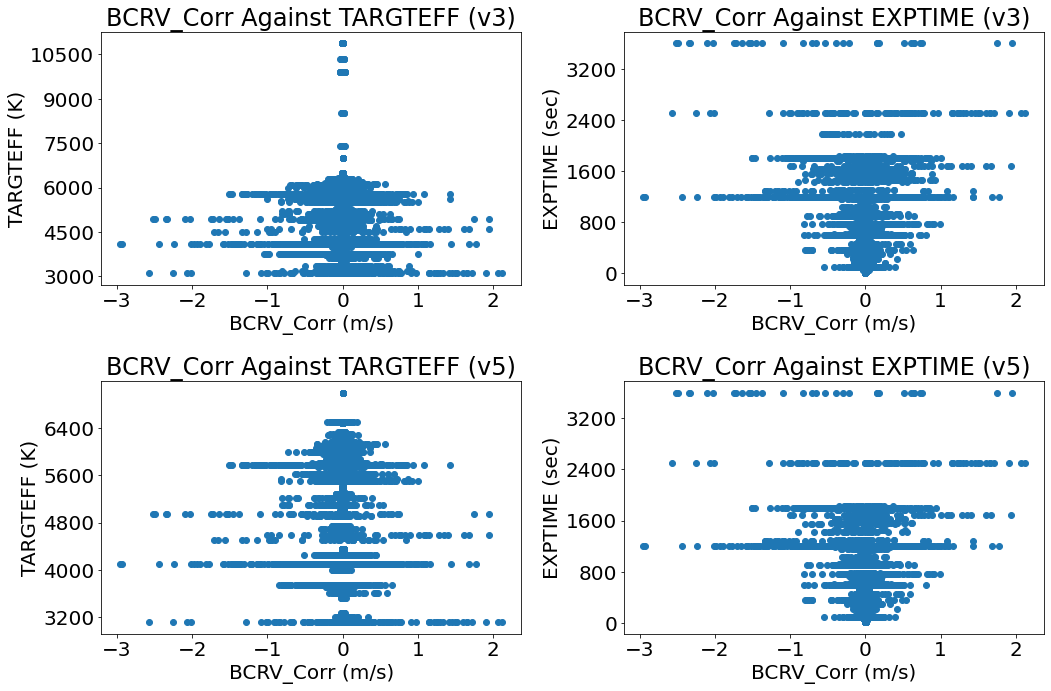

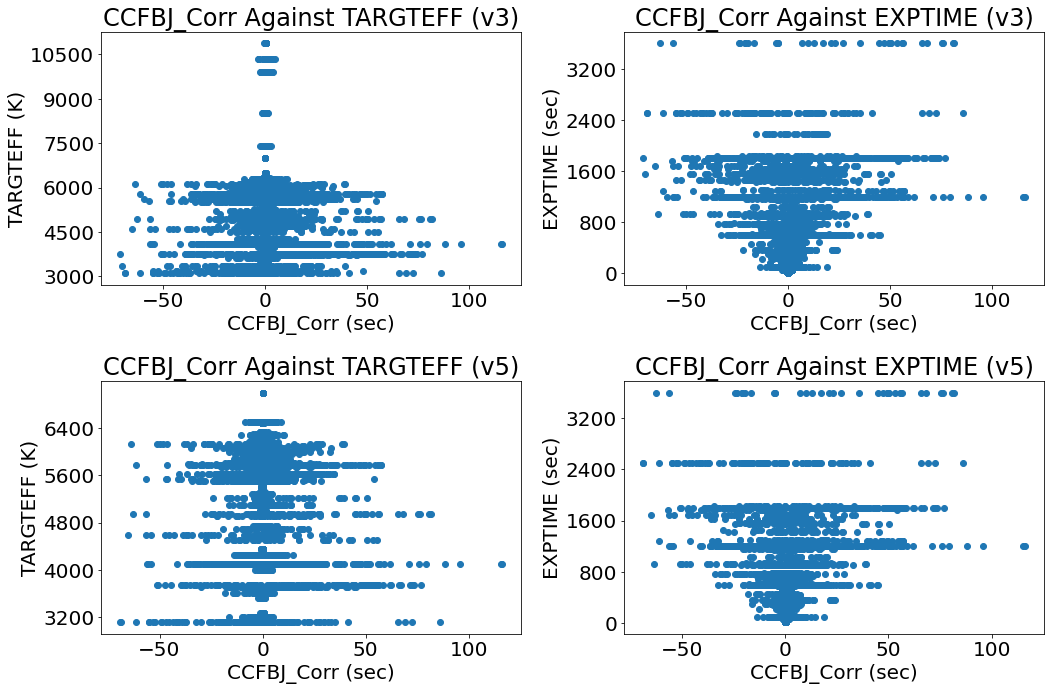

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes[0][0].scatter(new_df['BCRV_Corr'], new_df['TARGTEFF'])
axes[0][0].set_title('BCRV_Corr Against TARGTEFF (v3)')
axes[0][0].set_xlabel('BCRV_Corr (m/s)')
axes[0][0].set_ylabel('TARGTEFF (K)')
axes[0][0].yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

axes[0][1].scatter(new_df['BCRV_Corr'], new_df['EXPTIME'])
axes[0][1].set_title('BCRV_Corr Against EXPTIME (v3)')
axes[0][1].set_xlabel('BCRV_Corr (m/s)')
axes[0][1].set_ylabel('EXPTIME (sec)')
axes[0][1].yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

axes[1][0].scatter(new_df2['BCRV_Corr'], new_df2['TARGTEFF'])
axes[1][0].set_title('BCRV_Corr Against TARGTEFF (v5)')
axes[1][0].set_xlabel('BCRV_Corr (m/s)')
axes[1][0].set_ylabel('TARGTEFF (K)')
axes[1][0].yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

axes[1][1].scatter(new_df2['BCRV_Corr'], new_df2['EXPTIME'])
axes[1][1].set_title('BCRV_Corr Against EXPTIME (v5)')
axes[1][1].set_xlabel('BCRV_Corr (m/s)')
axes[1][1].set_ylabel('EXPTIME (sec)')
axes[1][1].yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes[0][0].scatter(new_df['CCFBJ_Corr'], new_df['TARGTEFF'])
axes[0][0].set_title('CCFBJ_Corr Against TARGTEFF (v3)')
axes[0][0].set_xlabel('CCFBJ_Corr (sec)')
axes[0][0].set_ylabel('TARGTEFF (K)')
axes[0][0].yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

axes[0][1].scatter(new_df['CCFBJ_Corr'], new_df['EXPTIME'])
axes[0][1].set_title('CCFBJ_Corr Against EXPTIME (v3)')
axes[0][1].set_xlabel('CCFBJ_Corr (sec)')
axes[0][1].set_ylabel('EXPTIME (sec)')
axes[0][1].yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

axes[1][0].scatter(new_df2['CCFBJ_Corr'], new_df2['TARGTEFF'])
axes[1][0].set_title('CCFBJ_Corr Against TARGTEFF (v5)')
axes[1][0].set_xlabel('CCFBJ_Corr (sec)')
axes[1][0].set_ylabel('TARGTEFF (K)')
axes[1][0].yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

axes[1][1].scatter(new_df2['CCFBJ_Corr'], new_df2['EXPTIME'])
axes[1][1].set_title('CCFBJ_Corr Against EXPTIME (v5)')
axes[1][1].set_xlabel('CCFBJ_Corr (sec)')
axes[1][1].set_ylabel('EXPTIME (sec)')
axes[1][1].yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

plt.tight_layout()
plt.show()

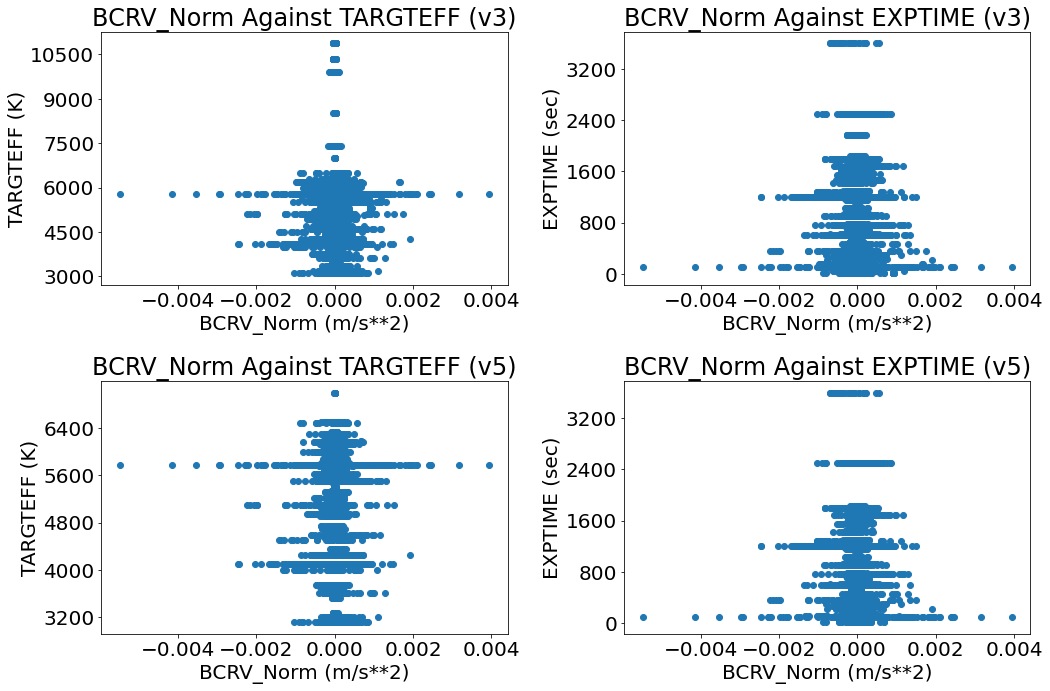

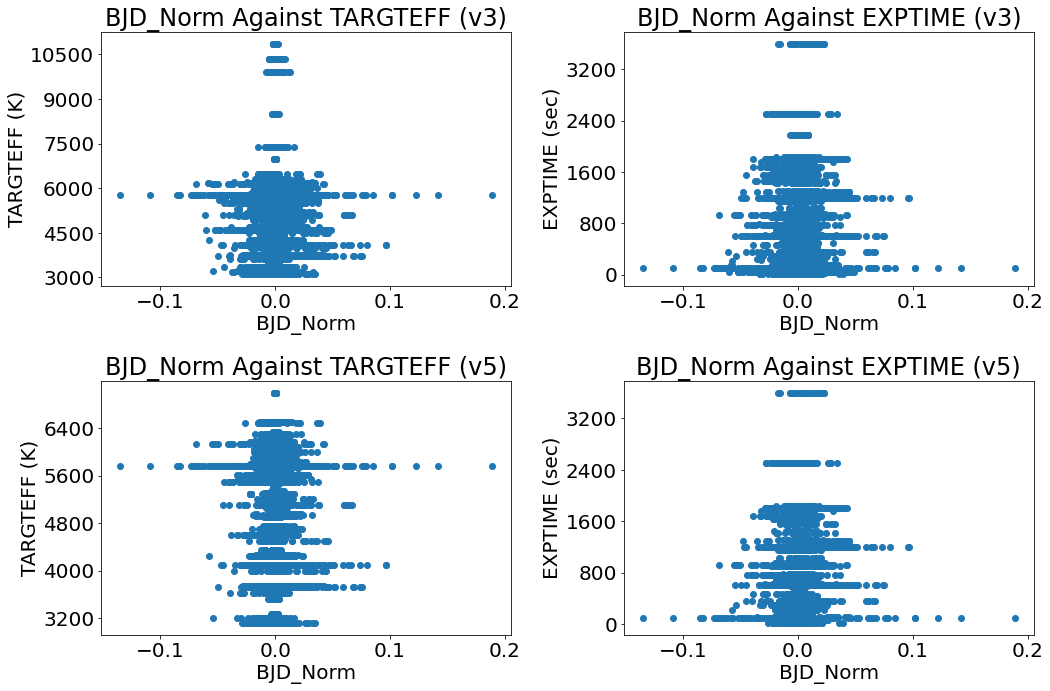

In [34]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes[0][0].scatter(new_df['BCRV_Norm'], new_df['TARGTEFF'])
axes[0][0].set_title('BCRV_Norm Against TARGTEFF (v3)')
axes[0][0].set_xlabel('BCRV_Norm (m/s**2)')
axes[0][0].set_ylabel('TARGTEFF (K)')
axes[0][0].yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

axes[0][1].scatter(new_df['BCRV_Norm'], new_df['EXPTIME'])
axes[0][1].set_title('BCRV_Norm Against EXPTIME (v3)')
axes[0][1].set_xlabel('BCRV_Norm (m/s**2)')
axes[0][1].set_ylabel('EXPTIME (sec)')
axes[0][1].yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

axes[1][0].scatter(new_df2['BCRV_Norm'], new_df2['TARGTEFF'])
axes[1][0].set_title('BCRV_Norm Against TARGTEFF (v5)')
axes[1][0].set_xlabel('BCRV_Norm (m/s**2)')
axes[1][0].set_ylabel('TARGTEFF (K)')
axes[1][0].yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

axes[1][1].scatter(new_df2['BCRV_Norm'], new_df2['EXPTIME'])
axes[1][1].set_title('BCRV_Norm Against EXPTIME (v5)')
axes[1][1].set_xlabel('BCRV_Norm (m/s**2)')
axes[1][1].set_ylabel('EXPTIME (sec)')
axes[1][1].yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes[0][0].scatter(new_df['BJD_Norm'], new_df['TARGTEFF'])
axes[0][0].set_title('BJD_Norm Against TARGTEFF (v3)')
axes[0][0].set_xlabel('BJD_Norm')
axes[0][0].set_ylabel('TARGTEFF (K)')
axes[0][0].yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

axes[0][1].scatter(new_df['BJD_Norm'], new_df['EXPTIME'])
axes[0][1].set_title('BJD_Norm Against EXPTIME (v3)')
axes[0][1].set_xlabel('BJD_Norm')
axes[0][1].set_ylabel('EXPTIME (sec)')
axes[0][1].yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

axes[1][0].scatter(new_df2['BJD_Norm'], new_df2['TARGTEFF'])
axes[1][0].set_title('BJD_Norm Against TARGTEFF (v5)')
axes[1][0].set_xlabel('BJD_Norm')
axes[1][0].set_ylabel('TARGTEFF (K)')
axes[1][0].yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

axes[1][1].scatter(new_df2['BJD_Norm'], new_df2['EXPTIME'])
axes[1][1].set_title('BJD_Norm Against EXPTIME (v5)')
axes[1][1].set_xlabel('BJD_Norm')
axes[1][1].set_ylabel('EXPTIME (sec)')
axes[1][1].yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

plt.tight_layout()
plt.show()

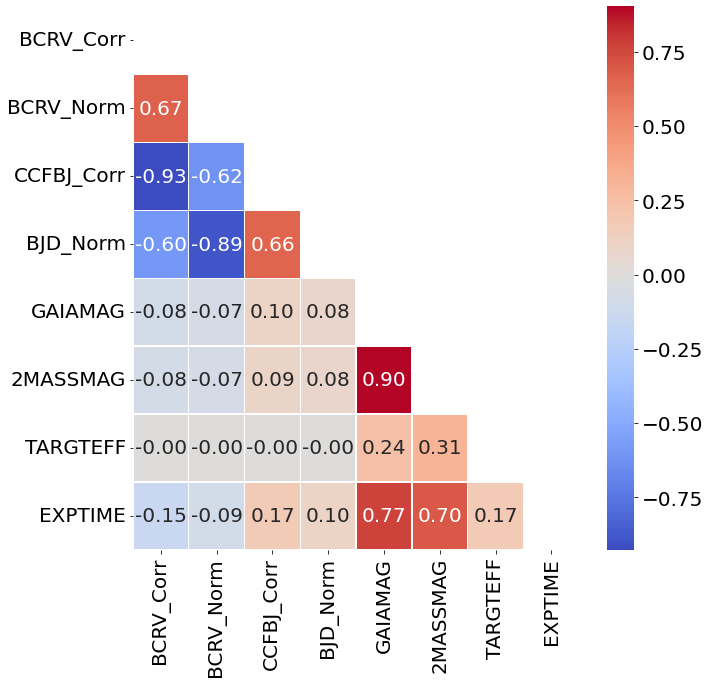

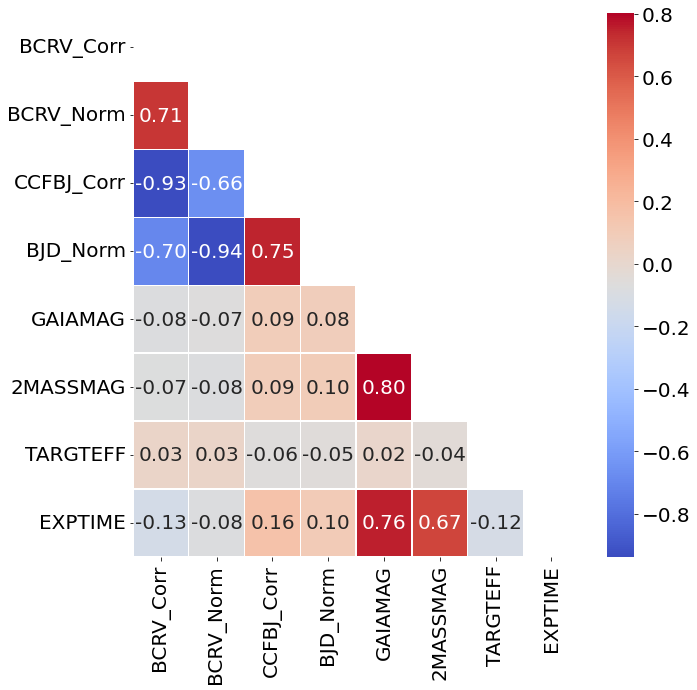

In [37]:
selected_columns = ['BCRV_Corr', 'BCRV_Norm', 'CCFBJ_Corr', 'BJD_Norm', 'GAIAMAG', '2MASSMAG', 'TARGTEFF', 'EXPTIME']
corr_matrix = new_df[selected_columns].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.xticks(rotation=90)

plt.show()

selected_columns = ['BCRV_Corr', 'BCRV_Norm', 'CCFBJ_Corr', 'BJD_Norm', 'GAIAMAG', '2MASSMAG', 'TARGTEFF', 'EXPTIME']
corr_matrix = new_df2[selected_columns].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.xticks(rotation=90)

plt.show()

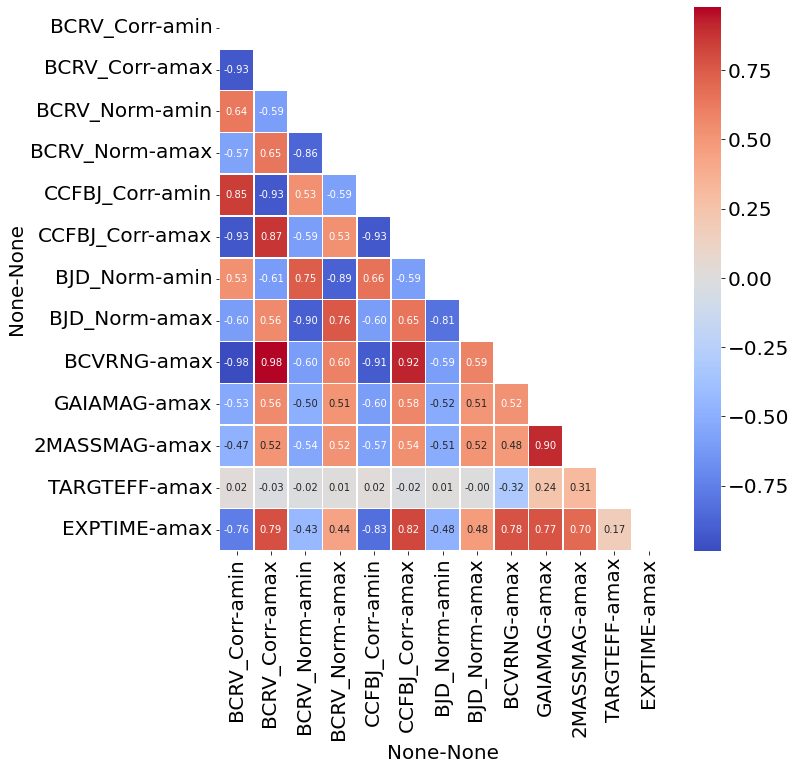

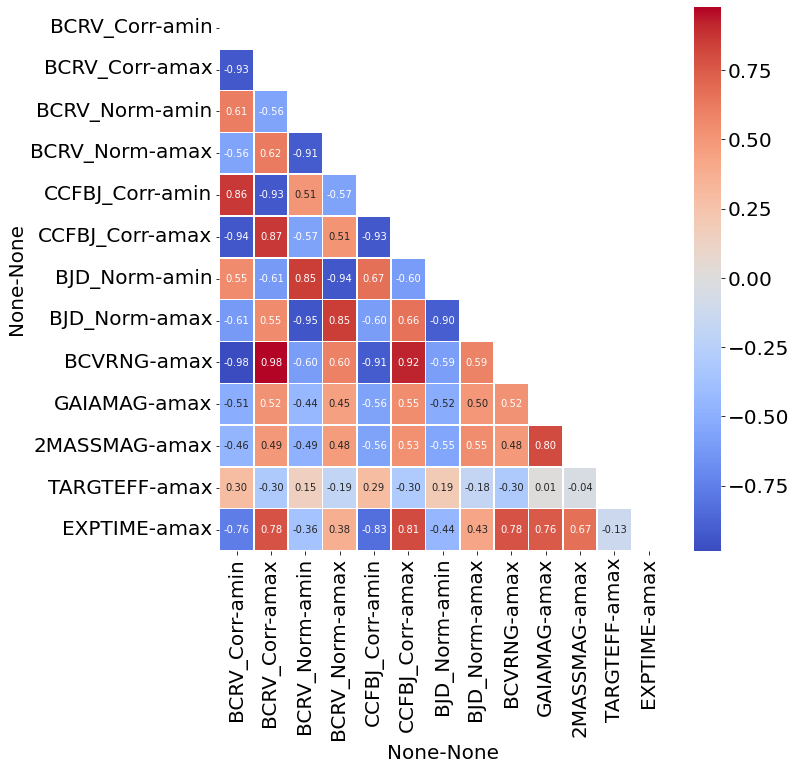

In [39]:
corr_matrix = grouped.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5,  annot_kws={"size": 10})
plt.xticks(rotation=90)

plt.show()

corr_matrix2 = grouped2.corr()
mask = np.triu(np.ones_like(corr_matrix2, dtype=bool))
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix2, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5,  annot_kws={"size": 10})
plt.xticks(rotation=90)

plt.show()

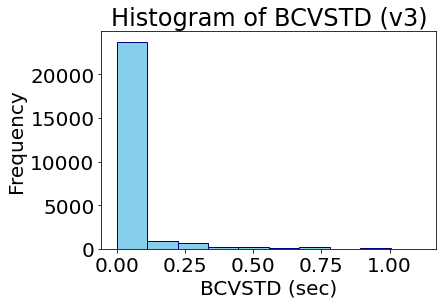

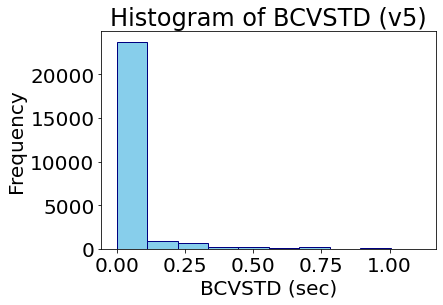

In [41]:
plt.hist(new_df['BCVSTD'], bins=10, color='skyblue', edgecolor='navy')
plt.title('Histogram of BCVSTD (v3)')
plt.xlabel("BCVSTD (sec)")
plt.ylabel("Frequency")
plt.show()

plt.hist(new_df2['BCVSTD'], bins=10, color='skyblue', edgecolor='navy')
plt.title('Histogram of BCVSTD (v5)')
plt.xlabel("BCVSTD (sec)")
plt.ylabel("Frequency")
plt.show()

In [42]:
new_df.loc[:, 'EMDATE_ns'] = (pd.to_datetime(new_df['EMDATE-E']) - pd.to_datetime(new_df['EMDATE-B']))
new_df.loc[:, 'EMDATE'] = new_df['EMDATE_ns'].dt.total_seconds()

new_df2.loc[:, 'EMDATE_ns'] = (pd.to_datetime(new_df2['EMDATE-E']) - pd.to_datetime(new_df2['EMDATE-B']))
new_df2.loc[:, 'EMDATE'] = new_df2['EMDATE_ns'].dt.total_seconds()

In [51]:
new_df = new_df.sort_values(by=['ORDER'], ascending=True)
new_df['DATE-MID'] = pd.to_datetime(new_df['DATE-MID'])

new_df2 = new_df2.sort_values(by=['ORDER'], ascending=True)
new_df2['DATE-MID'] = pd.to_datetime(new_df2['DATE-MID'])

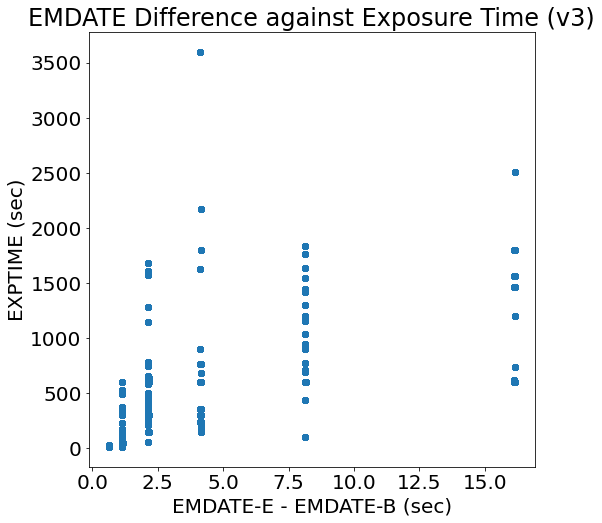

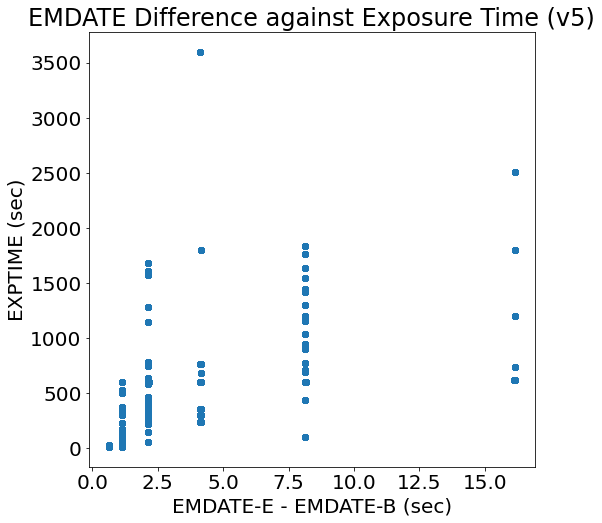

In [43]:
plt.figure(figsize=(8, 8))
plt.scatter(new_df['EMDATE'], new_df['EXPTIME'])
plt.title("EMDATE Difference against Exposure Time (v3)")
plt.xlabel("EMDATE-E - EMDATE-B (sec)")
plt.ylabel("EXPTIME (sec)")
plt.show()

plt.figure(figsize=(8, 8))
plt.scatter(new_df2['EMDATE'], new_df2['EXPTIME'])
plt.title("EMDATE Difference against Exposure Time (v5)")
plt.xlabel("EMDATE-E - EMDATE-B (sec)")
plt.ylabel("EXPTIME (sec)")
plt.show()

In [47]:
#creating percent change deviation for BCRV and BJD
new_df.loc[:, 'BCRV_Perc'] = (new_df['BCRV'].astype(float) - new_df['CCFBCV'].astype(float)) / (new_df['CCFBCV'].astype(float)) * 100
new_df.loc[:, 'BJD_Perc'] = (new_df['CCFBJD'].astype(float) - new_df['CCFBJD_Avg'].astype(float)) / new_df['CCFBJD_Avg'].astype(float) * 100

#creating percent change deviation for BCRV and BJD
new_df2.loc[:, 'BCRV_Perc'] = (new_df2['BCRV'].astype(float) - new_df2['CCFBCV'].astype(float)) / (new_df2['CCFBCV'].astype(float)) * 100
new_df2.loc[:, 'BJD_Perc'] = (new_df2['CCFBJD'].astype(float) - new_df2['CCFBJD_Avg'].astype(float)) / new_df2['CCFBJD_Avg'].astype(float) * 100


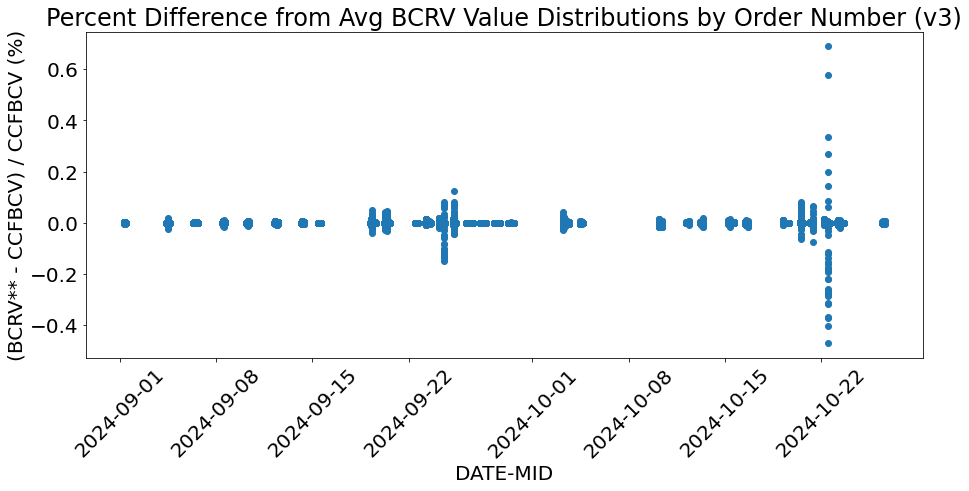

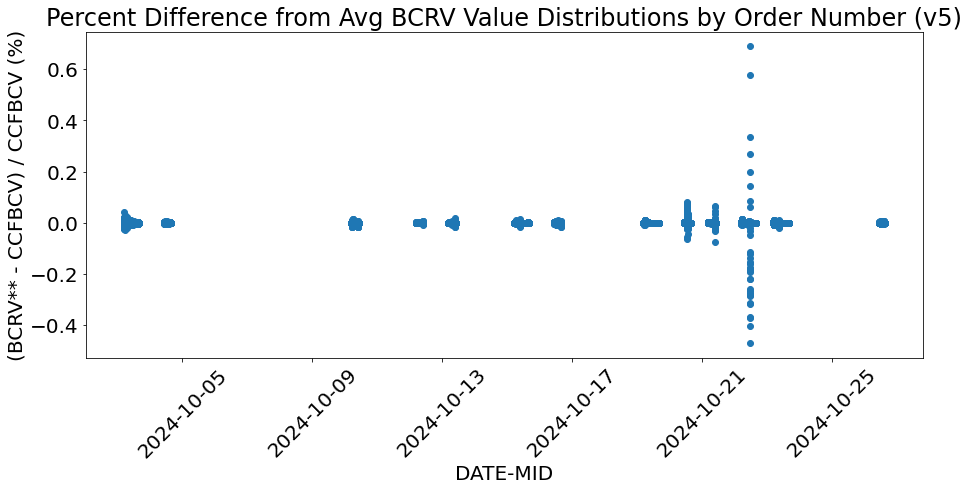

In [52]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(15, 6))
plt.scatter(new_df['DATE-MID'], new_df['BCRV_Perc']) 
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.title("Percent Difference from Avg BCRV Value Distributions by Order Number (v3)")
plt.ylabel('(BCRV** - CCFBCV) / CCFBCV (%)')
plt.xlabel('DATE-MID')
plt.show()

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(15, 6))
plt.scatter(new_df2['DATE-MID'], new_df2['BCRV_Perc'])
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.title("Percent Difference from Avg BCRV Value Distributions by Order Number (v5)")
plt.ylabel('(BCRV** - CCFBCV) / CCFBCV (%)')
plt.xlabel('DATE-MID')
plt.show()

In [49]:
Sort_High = new_df.sort_values(by=['BCRV_Perc'], ascending=False)
print(Sort_High[['BCRV_Perc', 'L0_filename']].head())

Sort_High2 = new_df2.sort_values(by=['BCRV_Perc'], ascending=False)
print(Sort_High2[['BCRV_Perc', 'L0_filename']].head())

        BCRV_Perc                L0_filename
288790   0.689437  KP.20241022.39422.56.fits
288791   0.577378  KP.20241022.39422.56.fits
288786   0.336957  KP.20241022.39422.56.fits
288787   0.269550  KP.20241022.39422.56.fits
288795   0.198016  KP.20241022.39422.56.fits
       BCRV_Perc                L0_filename
39349   0.689438  KP.20241022.39422.56.fits
39350   0.577378  KP.20241022.39422.56.fits
39345   0.336957  KP.20241022.39422.56.fits
39346   0.269550  KP.20241022.39422.56.fits
39354   0.198016  KP.20241022.39422.56.fits
